In [1]:
from collections import Counter
from collections import defaultdict
import scanpy as sc
import scrublet as scr
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import anndata
import harmonypy
%matplotlib inline

/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Subset the combined data to only keep fbm and ABM for this comparison

In [3]:
adata = sc.read("../data/abm_fbm_liver_concat_110520_downsampled_1000.h5ad")

In [ ]:
adata.var.to_csv("./")

In [29]:
#Introduce variables
#name of first object
data1 = "fetal"
#name of second object
data2 = "_adult"
common_cat = "corr_concat" 

In [20]:
adata.obs["origin_concat"]

index
MantonBM1_HiSeq_1-AAACCTGCATCGATGT-1          Pre B cell_adult
MantonBM1_HiSeq_1-AAACCTGCATTCCTGC-1      CD56 bright NK_adult
MantonBM1_HiSeq_1-AAACCTGTCACCTCGT-1           mature NK_adult
MantonBM1_HiSeq_1-AAACGGGCACGGTTTA-1               T reg_adult
MantonBM1_HiSeq_1-AAACGGGTCGCCTGAG-1                 DC2_adult
                                                 ...          
TTTCAGTTCGCGATCG-1-WSSS_F_BON8710643      late erythroid_fetal
TTTCATGAGCTTAAGA-1-WSSS_F_BON8710643     Immature B cell_fetal
TTTCATGCAGCTCATA-1-WSSS_F_BON8710643        promyelocyte_fetal
TTTCGATGTACGATGG-1-WSSS_F_BON8710643      late erythroid_fetal
TTTGTTGTCAATGTCG-1-WSSS_F_BON8710643    Pro B progenitor_fetal
Name: origin_concat, Length: 50782, dtype: category
Categories (131, object): [B cell_fetal, CD4 T_fetal, CD8 T_fetal, CD14 monocyte_adult, ..., tip EC_fetal, transitional B cell_adult, transitional DC _adult, transitional NK_adult]

# PCA

In [21]:
#sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
#%% PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=False, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:01:55)


# Assorted Regression and Correlation Functions

In [30]:
def pseudo_bulk(adata, groupby, use_rep='X', highly_variable=False, FUN=np.mean):
    """Make pseudo bulk data from grouped sc data
    """
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    if highly_variable:
        if isinstance(highly_variable, (list, tuple)):
            k_hv = adata.var_names.isin(highly_variable)
        else:
            k_hv = adata.var['highly_variable'].values
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        summarised[i] = FUN(x[k_grp, :], axis=0, keepdims=True)
    return pd.DataFrame(summarised.T, columns=groups, index=features)


def plot_df_heatmap(df, cmap='viridis', title=None, figsize=(7, 7), rotation=90, save=None, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=cmap, aspect='auto', **kwargs)
    if 0 < rotation < 90:
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'center'
    plt.xticks(
        range(len(df.columns)),
        df.columns,
        rotation=rotation,
        horizontalalignment=horizontalalignment,
    )
    plt.yticks(range(len(df.index)), df.index)
    if title:
        fig.suptitle(title)
    #fig.colorbar(im)
    if save:
        plt.savefig(fname=save, bbox_inches='tight', pad_inches=0.1)


def LR_annotate(                                                                                                                                                                                                                                                         
        adata,
        train_label,
        train_x,
        use_rep='X',
        subset_train=None,
        subset_predict=None,
        penalty='l1',
        sparcity=0.2,
        return_label=False,
):
    """Annotate cells using logistic regression
    """
    if subset_train is not None:
        train_label = train_label[subset_train]
        train_x = train_x[subset_train, :]
        
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(penalty=penalty, C=sparcity)
    lr.fit(train_x, train_label)
    
    if use_rep == 'X':
        predict_x = adata.X
    #if use_rep in adata.layers.keys():
    #    predict_x = adata.layers[use_rep]
    elif use_rep in adata.obsm.keys():
        predict_x = adata.obsm[use_rep]
        
    if subset_predict is not None:
        predict_x = predict_x[subset_train]
        predict_x.index = adata.obs[subset_predict].index
    
    if return_label:
        predict = lr.predict(predict_x)
        adata.obs['LR_predicted'] = adata.obs.index
        adata.obs['LR_predicted'] = adata.obs['LR_predicted'].map(predict[0])
    else:
        return lr.predict_proba(predict_x)
    


def cross_table(adata, x, y, normalise=None, highlight=False, subset=None):                                                                                                                                                                                              
    """Make a cross table comparing two categorical annotations
    """
    x_attr = adata.obs[x]
    y_attr = adata.obs[y]
    if subset is not None:
        x_attr = x_attr[subset]
        y_attr = y_attr[subset]
    #assert not _is_numeric(x_attr.values), f'Can not operate on numerical {x}'
    #assert not _is_numeric(y_attr.values), f'Can not operate on numerical {y}'
    crs_tbl = pd.crosstab(x_attr, y_attr)
    if normalise == 'x':
        x_sizes = x_attr.groupby(x_attr).size().values
        crs_tbl = (crs_tbl.T / x_sizes).round(2).T
    elif normalise == 'y':
        y_sizes = x_attr.groupby(y_attr).size().values
        crs_tbl = (crs_tbl / y_sizes).round(2)
    if highlight:
        return crs_tbl.style.background_gradient(cmap='viridis', axis=0)
    return crs_tbl

# Modified and working Logist regression script

In [31]:
def LR_compare(adata, train_x ,train_label,subset_predict, subset_train,penalty='l2',sparcity=0.2,col_name='predicted'):
    #Define LR parameters
    penalty='l2'
    sparcity=0.2
    lr = LogisticRegression(penalty=penalty, C=sparcity)

    if train_x == 'X':
        #train_label = adata.obs[common_cat].values
        #train_label = train_label[subset_train]
        train_x = adata.X
        predict_x = train_x[:]
        train_x = train_x[subset_train, :]
        predict_x = predict_x[subset_predict]


    elif train_x in adata.obsm.keys():
        #Define training parameters
        #train_label = adata.obs[common_cat].values
        #train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]

        #Define Prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

        
    #Train predictive model
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    #Create prediction table and map to adata.obs
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

In [32]:
adata.obsm["X_pca"]

array([[ -8.629215  ,   3.1868947 ,  -8.590192  , ...,  -0.41015816,
          0.28630778,  -0.8934657 ],
       [  6.359536  ,  -4.5381184 , -10.7276    , ...,  -0.96390843,
          0.16967301,  -1.8950891 ],
       [ 10.303388  ,  -3.0499473 ,  -8.606842  , ...,  -2.0740106 ,
         -0.47149873,  -0.74319816],
       ...,
       [ -8.459578  ,  -6.4661016 ,   3.951989  , ...,  -1.1507071 ,
         -0.28389037,  -0.86213464],
       [ 33.498104  ,  24.146864  ,   8.734967  , ...,  -0.4284715 ,
          1.279621  ,  -1.1287601 ],
       [ -5.8476396 ,   0.67539823,  -3.4705527 , ...,  -0.07140154,
          0.78060293,   1.6575139 ]], dtype=float32)

# Logistic Regression Classifier

In [33]:
#Define the seprator category in the column of interest, this works by partial matches and enables a-symmetric comparisons
Data1_group = data1
Data2_group = data2

#Define the common .obs column between cancatinated data
common_cat = "origin_concat"

#Define the resource to train and predict on, PCA or X or UMAP (#if you wish to use gene expression, train_x = 'X' or 'X_pca' , or 'X_umap'
#train_x = 'X'
train_x = 'X_pca'
########################################################################################
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
group1 = list(group1)
group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
group2 = list(group2)
subset_predict = np.array(adata.obs[common_cat].isin(group2))
subset_train = np.array(adata.obs[common_cat].isin(group1))
#train_label = adata.obs[common_cat].values
#train_label = adata.obs[common_cat].values
train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values
#########################################################################################

In [34]:
LR_compare(adata, train_x,train_label,subset_predict, subset_train,sparcity=0.2,col_name='predicted')

/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

In [35]:
adata.obs["predicted"]

index
MantonBM1_HiSeq_1-AAACCTGCATCGATGT-1        pre-B cell_fetal
MantonBM1_HiSeq_1-AAACCTGCATTCCTGC-1    CD56 bright NK_fetal
MantonBM1_HiSeq_1-AAACCTGTCACCTCGT-1    CD56 bright NK_fetal
MantonBM1_HiSeq_1-AAACGGGCACGGTTTA-1             CD4 T_fetal
MantonBM1_HiSeq_1-AAACGGGTCGCCTGAG-1          Monocyte_fetal
                                                ...         
TTTCAGTTCGCGATCG-1-WSSS_F_BON8710643                     NaN
TTTCATGAGCTTAAGA-1-WSSS_F_BON8710643                     NaN
TTTCATGCAGCTCATA-1-WSSS_F_BON8710643                     NaN
TTTCGATGTACGATGG-1-WSSS_F_BON8710643                     NaN
TTTGTTGTCAATGTCG-1-WSSS_F_BON8710643                     NaN
Name: predicted, Length: 50782, dtype: object

In [36]:
#Save concat_data
#adata.write("concat_ys_SS2.h5ad")

In [37]:
#adata = sc.read("concat_ys_SS2.h5ad")

In [38]:
#adata = adata_concat

In [39]:
common_cat = "origin_concat"
adata_concat = adata[:]
adata = adata[adata.obs["predicted"].isin(group1)]

In [40]:
# The results, are displayed in a python notebook or rendered as a html
crs_tbl = cross_table(adata, x='predicted', y = common_cat, highlight=True)
crs_tbl

# Plot LR as a highlighted table by percentage

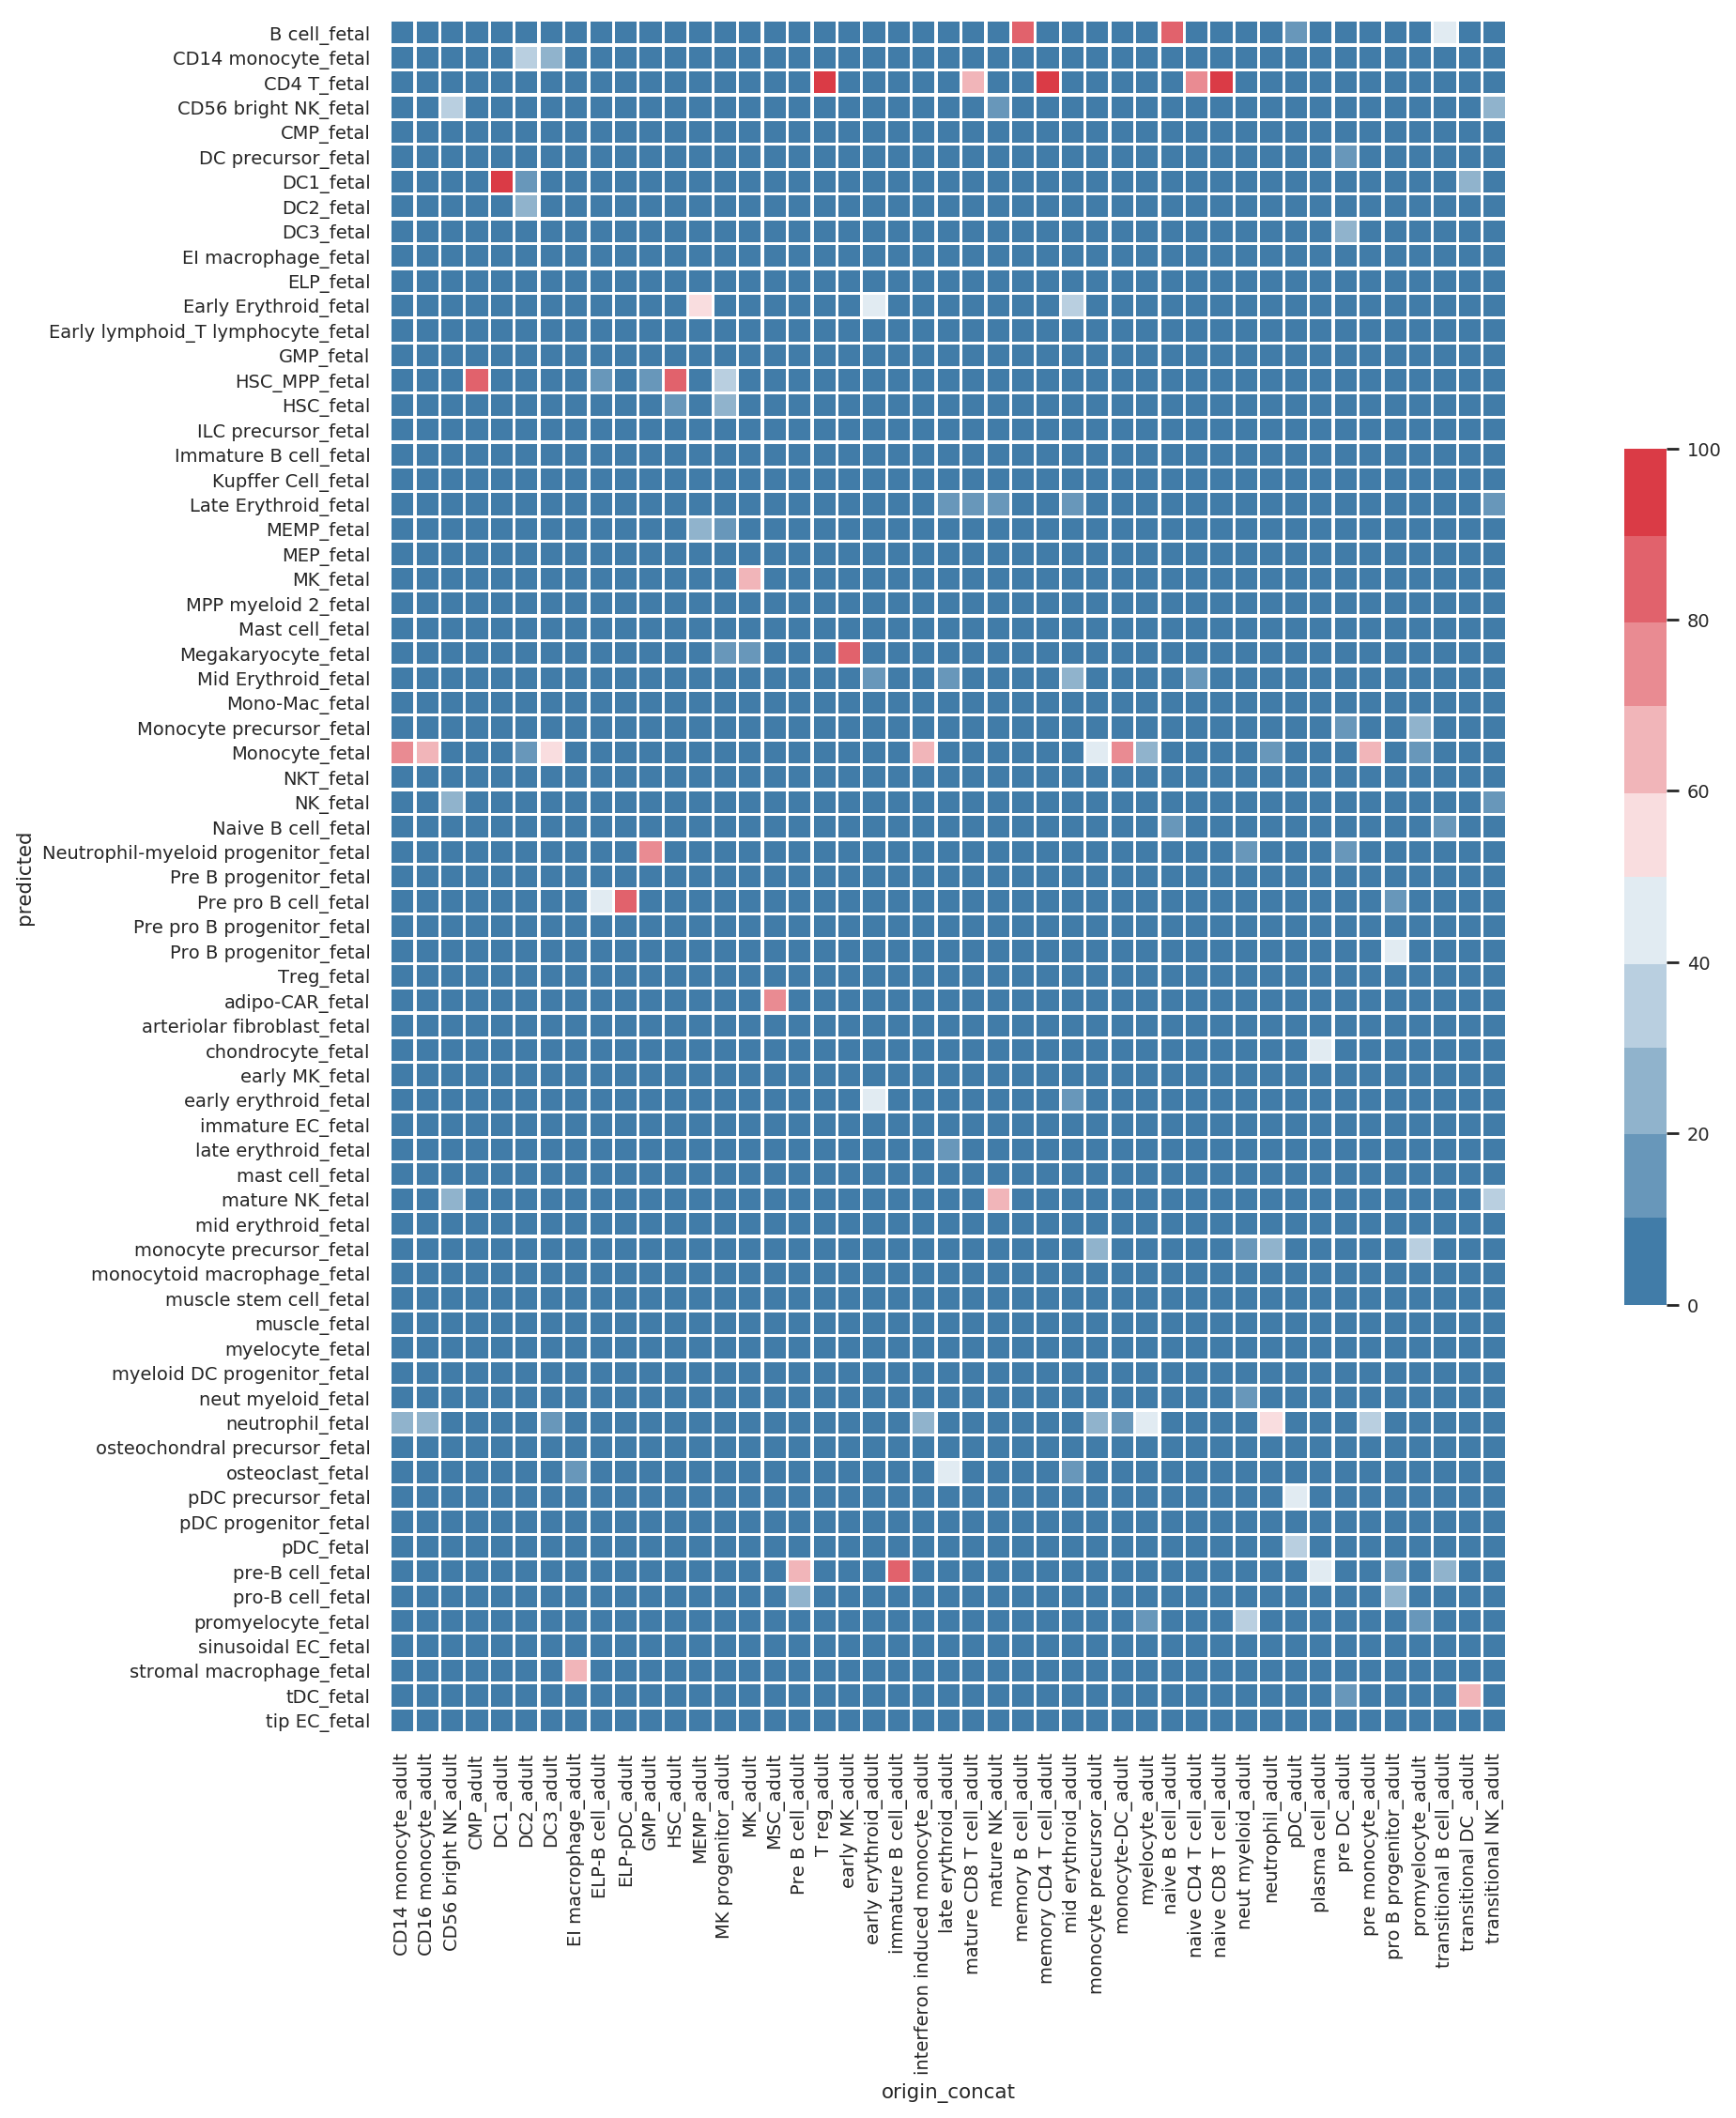

In [41]:
x='predicted'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, figsize=figsize, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
#g = sns.clustermap(crs_tbl.T, cmap=pal,vmin=20, vmax=70,linewidths=.5)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100,linewidths=1 ,center=50,square=True,cbar_kws={"shrink": 0.5})
plt.savefig("./LR_predictions_fbm_f_liver.png")

In [76]:
crs_tbl.to_csv("./crs_table.csv")

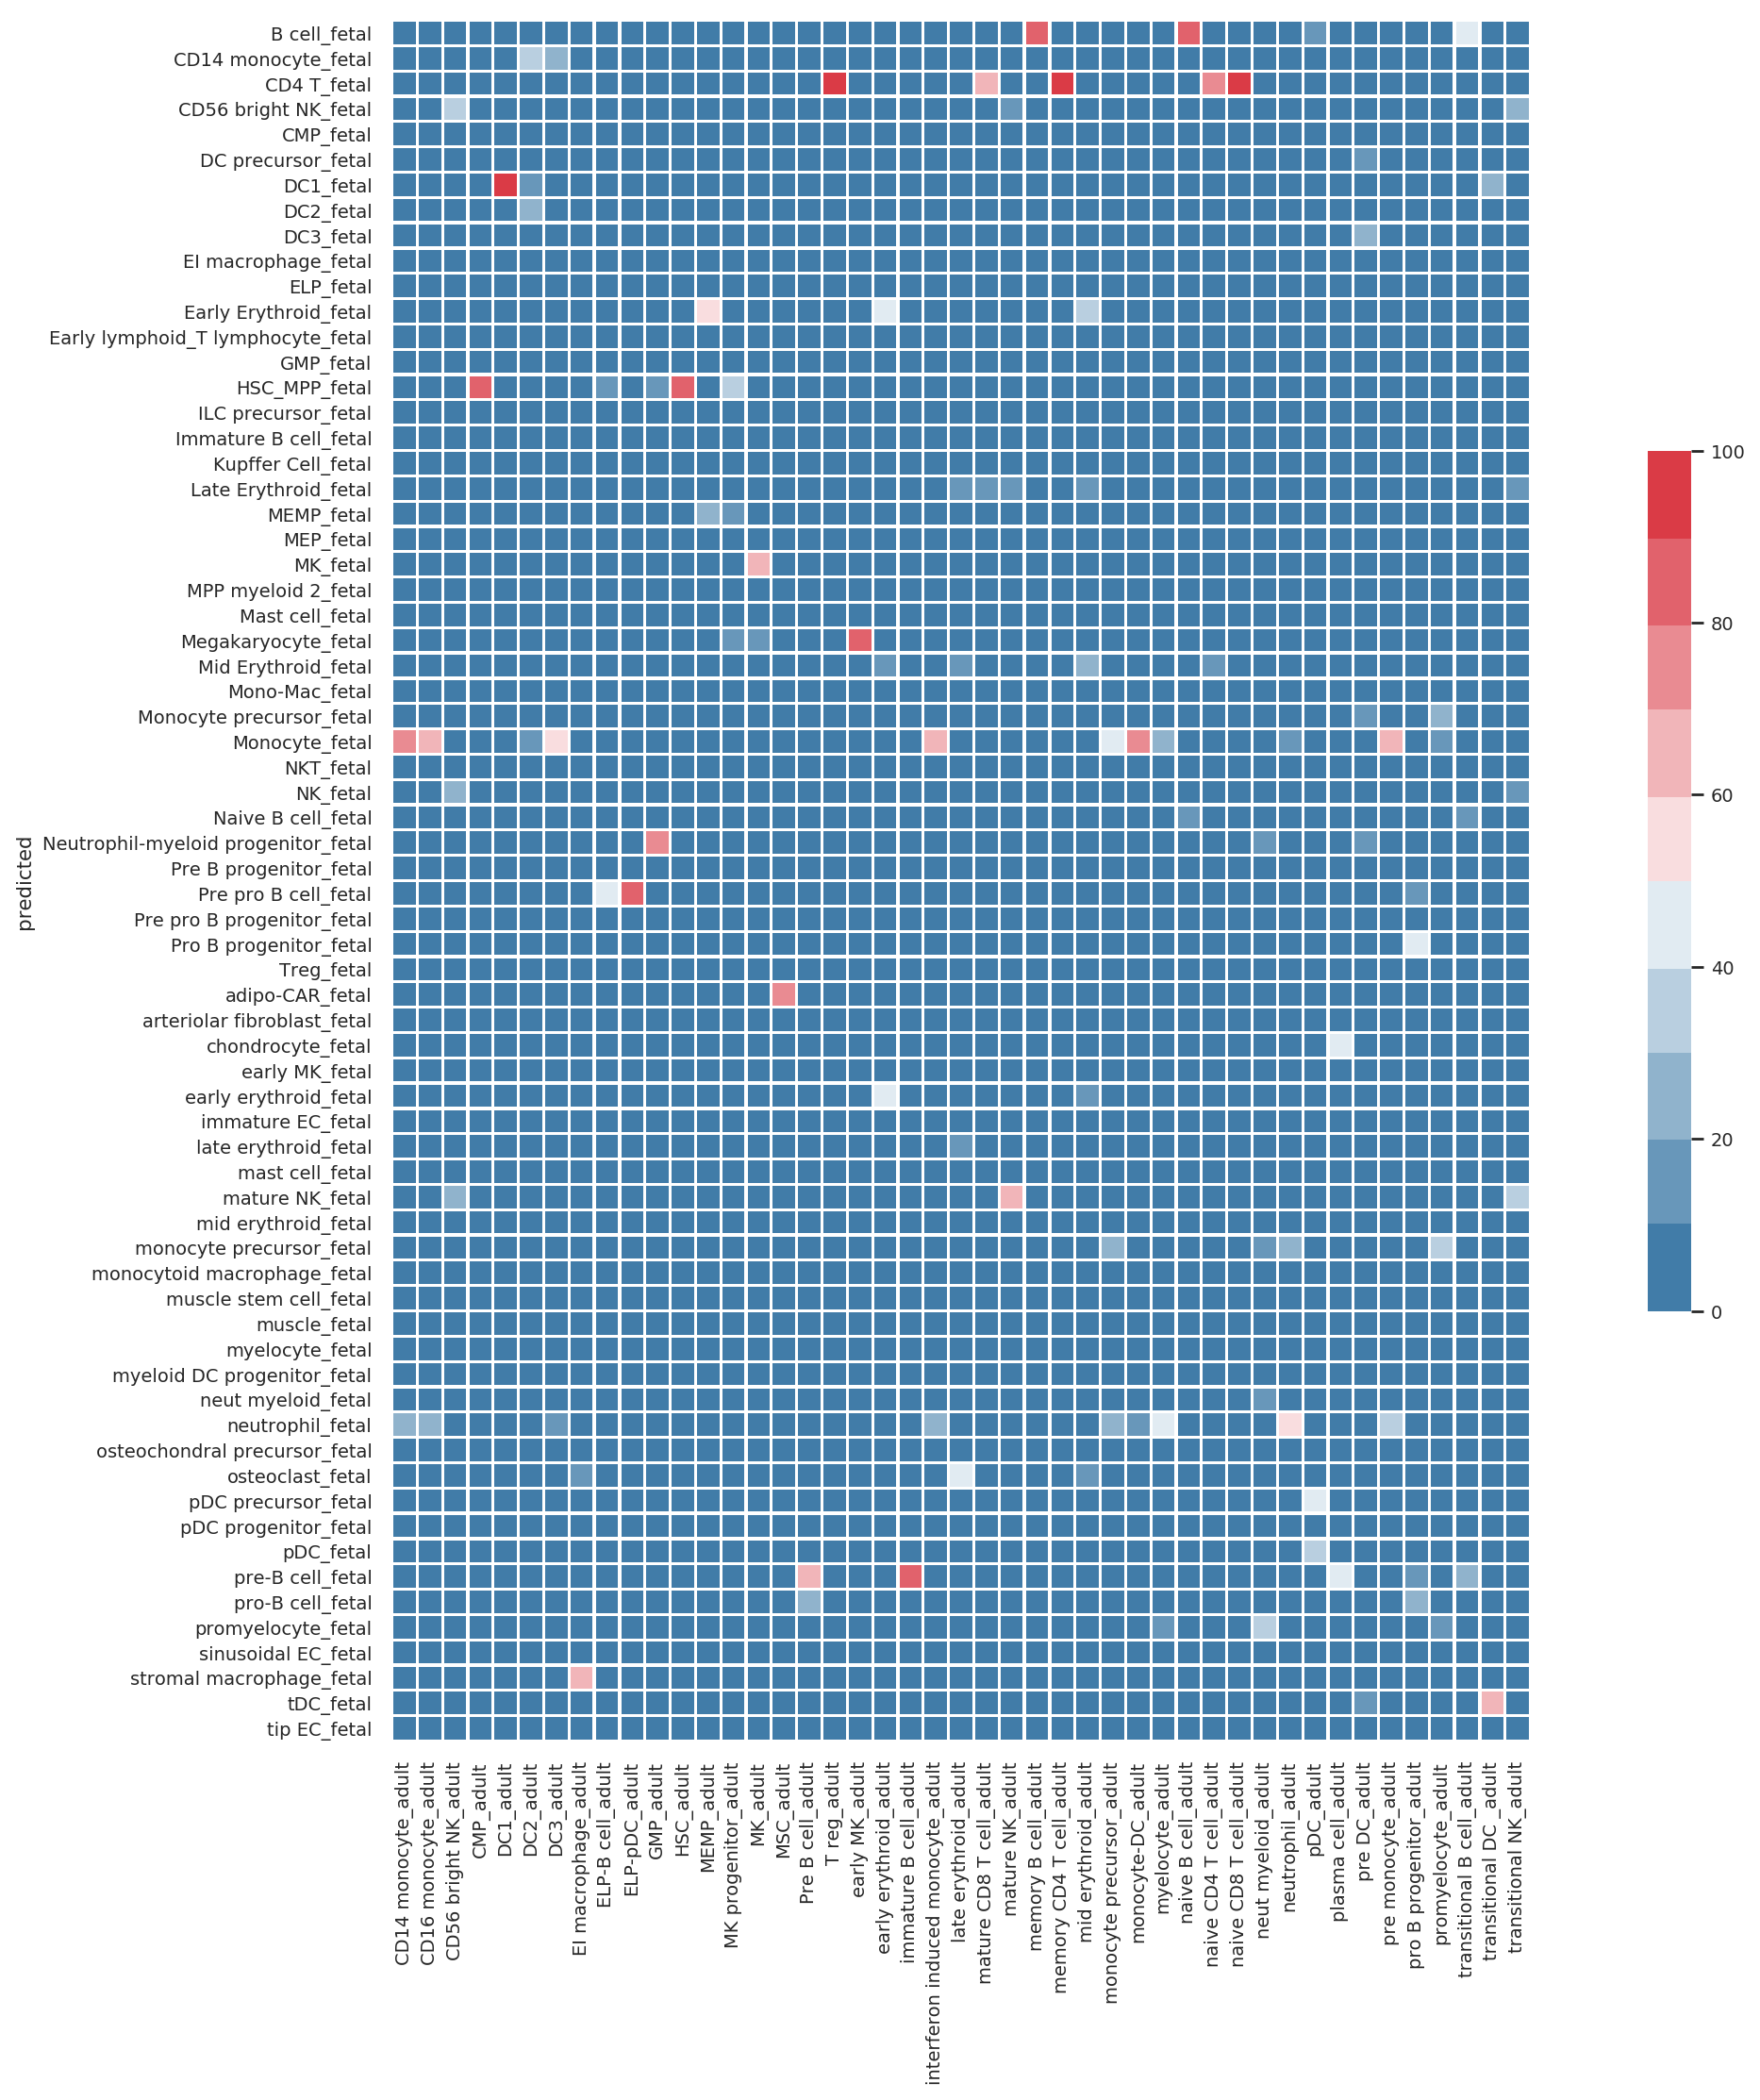

In [88]:
crs_tbl = pd.read_csv("./crs_table.csv",index_col = 0)
#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, figsize=figsize, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
#g = sns.clustermap(crs_tbl.T, cmap=pal,vmin=20, vmax=70,linewidths=.5)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100,linewidths=1 ,center=50,square=True,cbar_kws={"shrink": 0.5})
plt.savefig("./LR_predictions_fbm_f_liver.png")

# Compute DEGS between HSCs of interest

In [48]:
adata = adata_concat

In [49]:
list(adata.obs["origin_concat"].unique())

['Pre B cell_adult',
 'CD56 bright NK_adult',
 'mature NK_adult',
 'T reg_adult',
 'DC2_adult',
 'memory B cell_adult',
 'pre DC_adult',
 'CMP_adult',
 'pre monocyte_adult',
 'naive B cell_adult',
 'immature B cell_adult',
 'late erythroid_adult',
 'mature CD8 T cell_adult',
 'naive CD8 T cell_adult',
 'pro B progenitor_adult',
 'GMP_adult',
 'interferon induced monocyte_adult',
 'neut myeloid_adult',
 'neutrophil_adult',
 'naive CD4 T cell_adult',
 'plasma cell_adult',
 'monocyte precursor_adult',
 'CD16 monocyte_adult',
 'memory CD4 T cell_adult',
 'ELP-pDC_adult',
 'transitional B cell_adult',
 'CD14 monocyte_adult',
 'HSC_adult',
 'myelocyte_adult',
 'MSC_adult',
 'mid erythroid_adult',
 'monocyte-DC_adult',
 'promyelocyte_adult',
 'MEMP_adult',
 'MK_adult',
 'pDC_adult',
 'MK progenitor_adult',
 'transitional NK_adult',
 'early erythroid_adult',
 'DC3_adult',
 'transitional DC _adult',
 'DC1_adult',
 'ELP-B cell_adult',
 'early MK_adult',
 'EI macrophage_adult',
 'Kupffer Cell_fet

In [57]:
adata_deg.obs["origin_concat"]

index
MantonBM1_HiSeq_1-ACCCACTCATTTCAGG-1                         HSC_adult
MantonBM1_HiSeq_1-ATGGGAGGTTAAGAAC-1                         HSC_adult
MantonBM1_HiSeq_1-CAGCATATCTGGCGTG-1                         HSC_adult
MantonBM1_HiSeq_1-CATCCACTCTTAGCCC-1                         HSC_adult
MantonBM1_HiSeq_1-CGACCTTCATCCTTGC-1                         HSC_adult
                                                               ...    
F51_boneMarrow_CD45+_FCAImmP7803028_5GEX_GTGCTTCAGTGGGTTG    HSC_fetal
F51_boneMarrow_CD45+_FCAImmP7803029_5GEX_CGATGTAAGAAGCCCA    HSC_fetal
F51_boneMarrow_CD45+_FCAImmP7803029_5GEX_GCGGGTTTCTTTCCTC    HSC_fetal
F51_boneMarrow_CD45+_FCAImmP7803029_5GEX_TCAGGTATCCAGTATG    HSC_fetal
F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_GAAATGACAGTATGCT    HSC_fetal
Name: origin_concat, Length: 592, dtype: category
Categories (2, object): [HSC_adult, HSC_fetal]

In [63]:
adata.obs["hsc"] = adata.obs["origin_concat"][:]
adata.obs["hsc"] = adata.obs["hsc"].replace("HSC_MPP_fetal","HSC_fetal")

In [64]:
adata_deg = adata[adata.obs["hsc"].isin(['HSC_fetal','HSC_adult'])]

ranking genes


/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'predicted' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:381: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:381: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/jovyan/my-conda-envs/workhorse/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


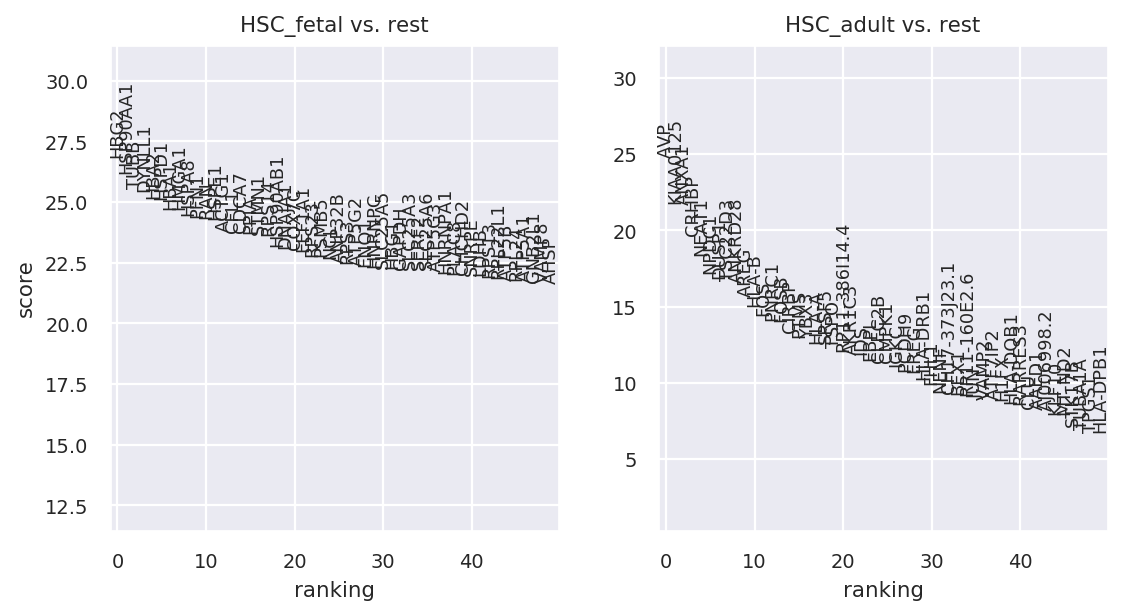

In [65]:
sc.tl.rank_genes_groups(adata_deg, "hsc", method='wilcoxon',groups=['HSC_fetal','HSC_adult'],n_genes=1000,log2fc_min=1)
sc.pl.rank_genes_groups(adata_deg, n_genes=50, sharey=False)

result = adata_deg.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(1000)

DE_name ="./DEGS_Abm_vs_fliver_HSC"
DE.to_csv(DE_name)

In [74]:
f_hsc_def_genes = DE.iloc[:,0:3]
f_hsc_def_genes.columns = ["genes","pval","logfc"]
abm_hsc_def_genes = DE.iloc[:,3:6]
abm_hsc_def_genes.columns = ["genes","pval","logfc"]

f_hsc_def_genes.to_csv("./fetal_hsc_gene_list.csv")
abm_hsc_def_genes.to_csv("./abm_hsc_gene_list.csv")

In [73]:
DE

,HSC_fetal_n,HSC_fetal_p,HSC_fetal_l,HSC_adult_n,HSC_adult_p,HSC_adult_l
0,HBG2,6.716924e-159,84.565552,AVP,4.758749e-136,11.083731
1,HSP90AA1,4.426024e-151,52.390194,KIAA0125,4.833610e-105,6.151456
2,TUBB,3.183688e-144,26.221344,ANXA1,2.102480e-104,6.109804
3,DYNLL1,6.406188e-143,11.946360,CRHBP,4.500169e-86,4.997758
4,HBA2,8.593750e-140,41.467709,NEAT1,3.996127e-75,4.498116
...,...,...,...,...,...,...
995,MSH6,2.092897e-30,3.390921,LINC00623,7.853738e-01,1.098573
996,MRPL47,2.156670e-30,2.205853,FZD1,7.853738e-01,1.098573
997,CCDC88A,2.202700e-30,2.860148,SALL2,7.860402e-01,0.834318
998,MEA1,2.351940e-30,2.540275,RBPMS,7.881885e-01,-0.068633


In [75]:
f_hsc_def_genes

,genes,pval,logfc
0,HBG2,6.716924e-159,84.565552
1,HSP90AA1,4.426024e-151,52.390194
2,TUBB,3.183688e-144,26.221344
3,DYNLL1,6.406188e-143,11.946360
4,HBA2,8.593750e-140,41.467709
...,...,...,...
995,MSH6,2.092897e-30,3.390921
996,MRPL47,2.156670e-30,2.205853
997,CCDC88A,2.202700e-30,2.860148
998,MEA1,2.351940e-30,2.540275
